In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read();return HTML(styles)
css_styling()

<figure>
<IMG SRC="images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Week 10: Empirical Orthogonal Functions (Principal Component Analysis)

<figure>
<IMG SRC="./images/nao_pc_djfm.gif" WIDTH=320 ALIGN="right" STYLE="padding-left:20px" ALT="http://en.wikipedia.org/wiki/Nyquist–Shannon_sampling_theorem">
</figure>

Often we are presented with space and time information, and relating the two can be difficult if we do not have a model that does so. To the right is a spatial pattern of sea-level pressure in the North Atlantic region.  The spatial pattern is the first "mode" of variance of the sea-level pressure (SLP) in the North Atlantic, and the pattern shows that when SLP is low in the north it is high in the south, and vice-versa.  The amplitude of this "mode" is in the lower plot, and we can see that there are periods of highs and lows and that they oscillate somewhat randomly.  Before carrying out this anlysis, there was really no strong theoretical reason to predict this pattern, and so finding it is an "emperical" result.  

Below we outline how this result was achieved, starting with a simple example.  Your project might want to try something similar to the example plotted here for the weather station data.

## Motivating example: 2-d pendulum

Suppose we have a pendulum swinging such that it traces out a straight (-ish) line in a 2-d plane $(x(t),y(t))=\mathbf{x}(t)$.  We take photographs so that we have a discrete timeseries $(x_n,y_n)=\mathbf{x}_n$ of the pendulum bob's location in 2-D space.  Furthermore, assume this is a real system, where the pendulum's location is not a perfect straight line, due to either noise in the measurement or imperfections in the pendulum.  

[ 2.90462126]


<IPython.core.display.Javascript object>


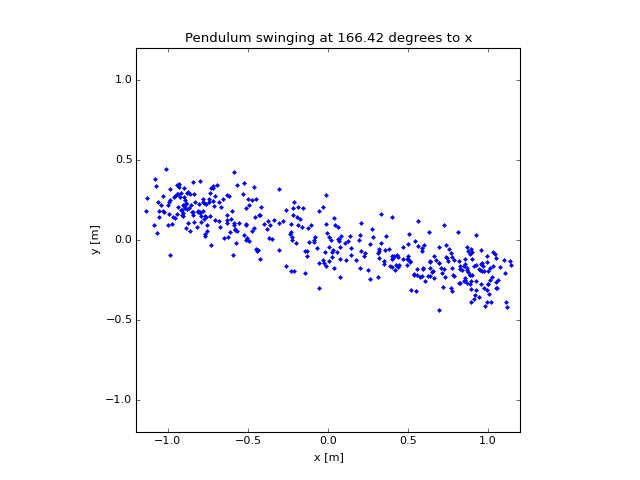

(<matplotlib.figure.Figure at 0x1049ac190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x107d7d790>)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
%matplotlib nbagg
# make a random angle for the pendulum to swing at

np.random.seed(431)
ang = np.random.rand(1)*np.pi
print ang

T = 2.1
t = np.arange(0,20.,0.05)
x = np.cos(ang)*np.sin(T*t*2*np.pi)+np.random.randn(len(t))*0.1
y = np.sin(ang)*np.sin(T*t*2*np.pi)+np.random.randn(len(t))*0.1
def plotit():
    fig,ax=plt.subplots(1,1)
    ax.plot(x,y,'.')
    ax.set_xlim([-1.2,1.2]);ax.set_ylim([-1.2,1.2])
    ax.set_aspect(1.);ax.set_xlabel('x [m]');ax.set_ylabel('y [m]');
    ax.set_title('Pendulum swinging at %1.2f degrees to x'%(ang*180/np.pi))
    return fig,ax
plotit()

Now, if we *knew* ahead of time that the pendulum was supposed to be swinging in a straight line, (i.e. we had an *a-priori* model) the smart thing to do would be to fit a straight line to this data: 

<IPython.core.display.Javascript object>


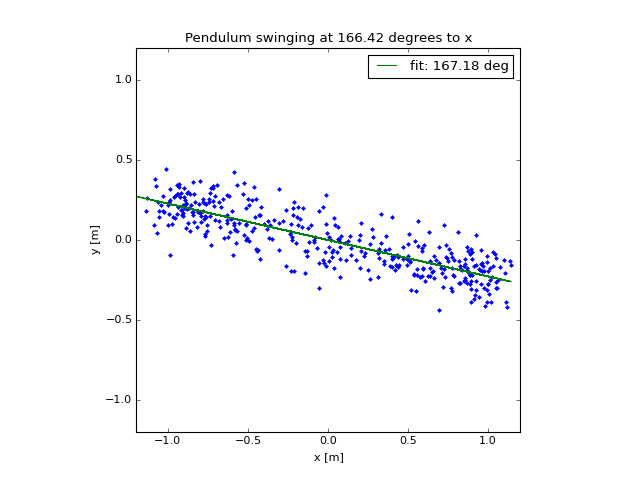

(<matplotlib.figure.Figure at 0x1087bcb90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1089b1a10>)

In [10]:
a=np.polyfit(x-np.mean(x),y-np.mean(y),1)
fitang=np.arctan(a[0])
def plotit2():
    fig,ax=plotit()
    ax.plot(x,a[0]*(x-np.mean(x))+np.mean(y),label='fit: %1.2f deg'%(fitang*180/np.pi+180))
    ax.legend(loc=0)
    return fig,ax
plotit2()

So we see that this fit gives an accurate direction for the pendulum swing, though its not exact because of the noise.

Equally sensible would be to rotate the data into an along-swing and across-swing axis.  Lets do this using matrix algebra:

$$\mathbf{x}' = \mathrm{R}\mathbf{x}$$

where $\mathrm{R}$ is the [Rotation Matrix](http://en.wikipedia.org/wiki/Rotation_matrix):

$$\mathrm{R}=\begin{pmatrix}\cos(\theta) &\sin(\theta)\\
-\sin(\theta) &\cos(\theta)\\
\end{pmatrix}
$$

(2, 400)


<IPython.core.display.Javascript object>


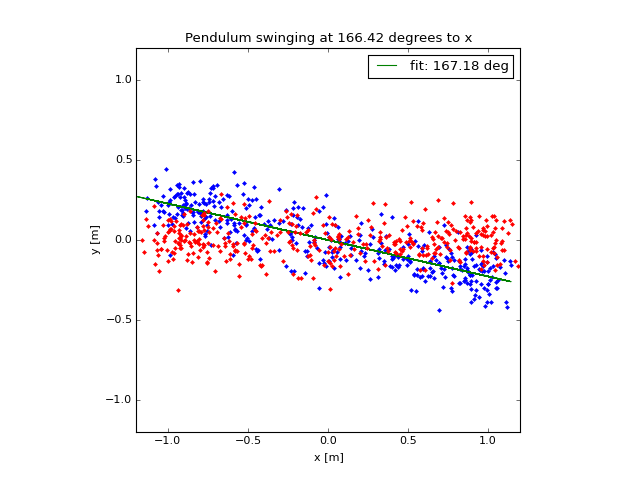

In [13]:
R = np.array([[np.cos(fitang),np.sin(fitang)],[-np.sin(fitang),np.cos(fitang)]])
xv=np.vstack((x,y))
print np.shape(xv)
xp = np.dot(R,xv) # this performs the matrix multiplication.
fig,ax=plotit2()
ax.plot(xp[0,:],xp[1,:],'r.')


Here we see that using the rotation, most of the variance has been put along the x axis.  Furthermore, we could guess that the x-axis data is no longer correlated with the y-axis data because that y-axis data is noise.  We can check this:

In [14]:
oldcorr=np.sum(xv[0,:]*xv[1,:])/np.sqrt(np.sum(xv[0,:]**2))/np.sqrt(np.sum(xv[1,:]**2))
newcorr=np.sum(xp[0,:]*xp[1,:])/np.sqrt(np.sum(xp[0,:]**2))/np.sqrt(np.sum(xp[1,:]**2))
print "Correlation co-efficient x,y un-rotated: %1.2f"%oldcorr
print "Correlation co-efficient x',y' rotated: %1.2f"%newcorr

Correlation co-efficient x,y un-rotated: -0.83
Correlation co-efficient x',y' rotated: -0.03


So, we have taken two highly correlated variables, and rotated them into un-correlated components.

For the pendulum we guessed that there was a straight line underlying the data, and used that *model* to remove the signal and get the cross-line noise component.  In real life the model may not be so obvious.  However, using matrix algebra, we can still find a rotation matrix that will allow us to decompose the signal into uncorrelated or "orthogonal" components.

## The EOF

The EOF uses the [covariance matrix](http://en.wikipedia.org/wiki/Covariance_matrix) of the data and decomposes it.  For discrete time series $x_n,y_n=\mathbf{x}$, where both $x_n$ and $y_n$ **have zero mean** and are of length $N$, the covariance matrix is $N\times N$ and given by:

$$\mathrm{C}=\mathbf{x}^T\cdot\mathbf{x}$$

which for our example is given by

$$\mathrm{C}=\frac{1}{N}\begin{pmatrix}\sum x_n^2 & \sum x_n y_n\\
\sum x_n y_n & \sum y_n^2\\
\end{pmatrix}$$

Note that $C$ is a symetric matrix.  Symetric matrices have nice properties.  In particular, they can be decomposed into a diagonal matrix times two eigenmatrices (see [wikipedia](http://en.wikipedia.org/wiki/Diagonalizable_matrix)):

$$\mathrm{C} = \mathrm{E}\mathrm{C'}\mathrm{E}^T$$

where $\mathrm{C}'$ is  a diagonal matrix (i.e. values along the diagonals, zeros everywhere else).

Now, think back to our example: the original covariance matrix was:

In [15]:
print np.cov(xv[0,:],xv[1,:])

[[ 0.48840351 -0.11109727]
 [-0.11109727  0.03645304]]


The new rotated covariance matrix is:

In [16]:
print np.cov(xp[0,:],xp[1,:])

[[ 0.51422495 -0.00241837]
 [-0.00241837  0.0106316 ]]


i.e. it is *almost* a diagonal matrix.  This gives us the idea that the covaraince matrix $\mathrm{C}'$ is the result of a rotation that gives us zero cross-correlation between our new vectors $x'$ and $y'$.  Furthermore it is trivial to see that $\mathbf{x}'=\mathrm{E}^T\mathbf{x}$ is the appropriate rotation because:

\begin{align}
\mathrm{C'}&=\mathbf{x'}\cdot\mathbf{x'}^T\\
&= (\mathrm{E}^T\mathbf{x})(\mathrm{E}^T\mathbf{x})^T\\
&= \mathrm{E}^T\mathbf{x} \mathbf{x}^T \mathrm{E}\\
&= \mathrm{E}^T \mathrm{C}\mathrm{E}\\
\end{align}

Fortunately, most linear algebra packages will give us $\mathrm{C}'$ and $\mathrm{E}$.  In python it is done via `np.linalg.eig`.  `eig` returns the diagonal of $\mathrm{C}'$, or the **eignevalues** of $\mathrm{C}$, and the **eigenvectors** which make up $\mathrm{E}$.

[ 0.51423656  0.01061999]
[[ 0.97401485 -0.22648414]
 [ 0.22648414  0.97401485]]
[[ 0.97509121 -0.22180424]
 [ 0.22180424  0.97509121]]


<IPython.core.display.Javascript object>


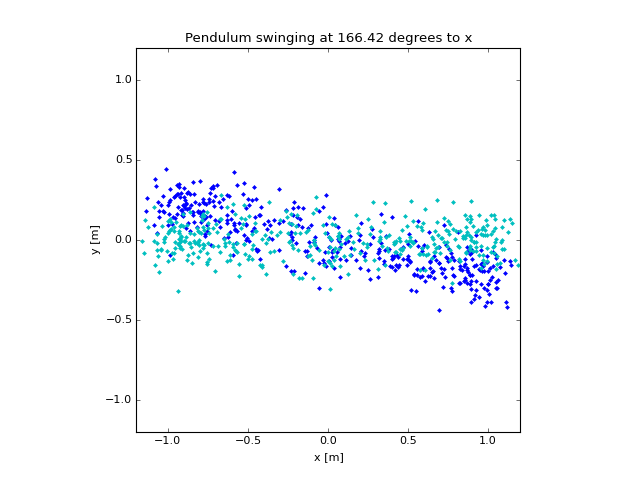

In [21]:
C=np.cov(xv[0,:],xv[1,:])
Cp,E=np.linalg.eig(C)
print Cp
print E.T
print R
xe=np.dot(E.T,xv)
fig,ax=plotit()
ax.plot(xe[0,:],xe[1,:],'c.')


Note that "rotating" by $\mathrm{E}^T$ gives almost the same answer as rotating by $\mathrm{R}$ which we derived from the linear fit.  

In [22]:
print np.cov(xp)
print np.cov(xe)

[[ 0.51422495 -0.00241837]
 [-0.00241837  0.0106316 ]]
[[  5.14236560e-01  -8.01711802e-18]
 [ -8.01711802e-18   1.06199903e-02]]


and note that the covariance of our new $x'_n$ and $y'_n$  are zero (within machine precision).

## Second example: Points of a vibrating string

The example above was kind of trivial, in that we could have looked at the data and fit a straight line.  What if we have more data points in space, and a more complicated system?  For this example imagine a vibrating string, attached at two ends like for a guitar or violin, and imagine we choose discrete locations to measure the strings displacement from rest.  We can call the distance along the string $x_n$; these are fixed in time. The displacement of the string at each $x_n$ is given by $y_n(t)$.  

Now, rather than simulating a string, lets consider the wave equation that governs the string's motion:

$$ \frac{\partial^2 y}{\partial t^2} - c_0^2 \frac{\partial^2 y}{\partial x^2} = 0$$

subject to initial conditions: $y(t=0)=y_0$, and $\frac{\partial y}{\partial t}(t=0) = 0$, $y(x=0)=0$ and $y(x=L)=0$.   We know this is separable, so 

$$ Y(x)T''(t) - c_0^2 Y''(x)T(t)=0$$

or gathering terms:

$$ c_0^2\frac{Y''(x)}{Y(x)}  = \frac{T''(t)}{T(t)}$$

For both side to be always equal, they both must equal a constant, and that leads to the harmonic ODEs, and $Y(x)$ is a sine-wave in $x$.  However, the only sine-waves that obey the boundary conditions at $x=0,L$ are $\sin(k_n x)$ where $k_n=n\pi/L$.  These harmonic functions are sine waves that fit inside the string precisely.  The time dependence is also a sine wave $T(t)=A \cos(\omega_n t)$ and we can derive the **dispersion relation** 

$$c_0^2 k_n^2 = -\omega_n^2$$.

Therefore $$y(x,t) = \sum_1^\infty A_n \sin(k_n x)\cos(c_ok_nt)$$ and we can invert from the initial condition to get

$$A_n = \int_0^L y_0(x) 2\sin(k_n x)\ \mathrm{d}x$$

So, below we make a fake discrete signal $y(x_n,t_m)$ using this set of physics.  Then we test if EOFs can return the harmonic functions $\sin(k_n x)$ with no a-priori fitting of the model.


<IPython.core.display.Javascript object>


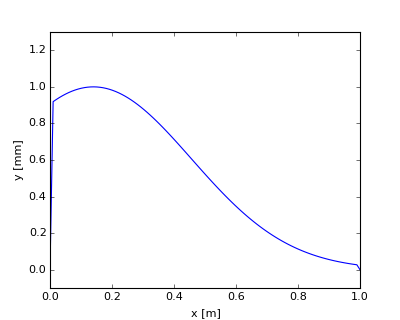

In [67]:
L = 1.
x = np.linspace(0,L,100)
c0=10.
# here is a pretty random initial condition.  
y0 = np.exp(-(x-0.14)**2/(2.*0.1))
y0[0]=0.0
y0[-1]=0.0
#y0 = 0*y0;
#y0[range(30,60,1)]=1.;
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(x,y0)
plt.ylim((-0.1,1.3))
plt.xlabel('x [m]')
plt.ylabel('y [mm]')

Note that this is a pretty violent pluck, and has been anchored to zero at the ends, so there is a sharp discontinuity near the beginning.  Now if there were no damping, this would just rattle around for ever, so we add some exponential damping, with stronger damping for the high-frequency motions.  Also, lets add some noise

<IPython.core.display.Javascript object>


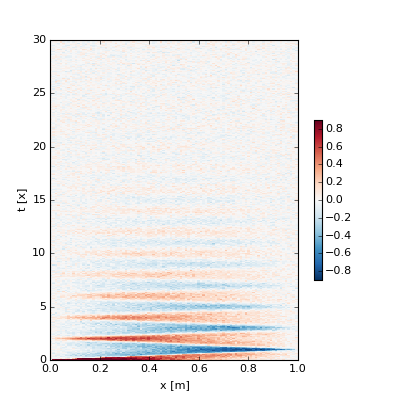

In [79]:
n = np.arange(1.,100.,1.)

k = n*np.pi/L
dx = np.median(np.diff(x))
A = 0.*n
for i in range(len(n)):
    A[i] = np.sum(y0*np.sin(k[i]*x))*dx*2

    
t=np.arange(0.,30.,0.1);
y=np.zeros((np.shape(t)[0],np.shape(x)[0]))
nt=0
for tn in range(np.shape(t)[0]):
    for i in range(len(n)):
        y[tn,:] = y[tn,:]+A[i]*np.sin(k[i]*x)*np.cos(k[i]*t[tn])*np.exp(-t[tn]*k[i]/20.)
    y[tn,:]=y[tn,:]+np.random.randn(1,np.shape(y)[1])/20.

fig,ax=plt.subplots(1,1,figsize=(5,5))
pcm=ax.pcolormesh(x,t,y,cmap=plt.cm.RdBu_r)
pcm.set_clim((-0.9,0.9))
fig.colorbar(pcm,ax=ax,shrink=0.5)
plt.xlabel('x [m]')
plt.ylabel('t [x]')


Now *we* know there is structure in $y(x)$ so we can fit the sine waves to the data to compare to our EOF below:

<IPython.core.display.Javascript object>


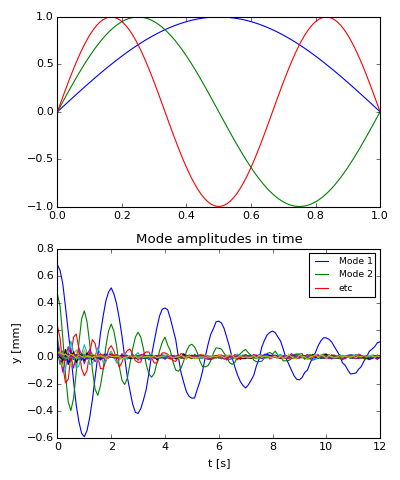

In [86]:
Am=np.zeros((np.shape(y)[0],20))

for tn in range(np.shape(y)[0]):
    for m in range(0,20):
        Am[tn,m]=np.sum(y[tn,:]*np.sin(k[m]*x)*dx)*2.

fig,axs=plt.subplots(2,1,figsize=(5,6))
ax=axs[0]
for m in range(3):
    ax.plot(x,np.sin(k[m]*x))
plt.xlabel('x [m]')
plt.ylabel('Mode Shape')

ax=axs[1]
for m in range(0,20):
    ax.plot(t,Am[:,m])
    
plt.legend(('Mode 1','Mode 2','etc'),fontsize='small')
plt.xlabel('t [s]')
plt.ylabel('y [mm]')
plt.xlim((0,12))
plt.title('Mode amplitudes in time')
plt.tight_layout()

So this is the amplitude of "Mode n", or $y_n(x)=A_n \sin(k_n x)$, where $k_n = n\pi/L$.  Note that the lowest mode (Mode -1) decays more slowly than the higher modes.

So, again, we had a model for what the response of ths string was going to be.  However, if we did not have a model, we would have turned to an EOF to see what the structure was:

### EOF of the string data

Using the EOF we hope that we can recover this expected analysis:


In [87]:
print np.shape(y)
C=np.cov(y.T)
print np.shape(C)

(300, 100)
(100, 100)


First note that the covariance matrix is 100x100, where 100 is the number of spaces that are sampled.

<IPython.core.display.Javascript object>


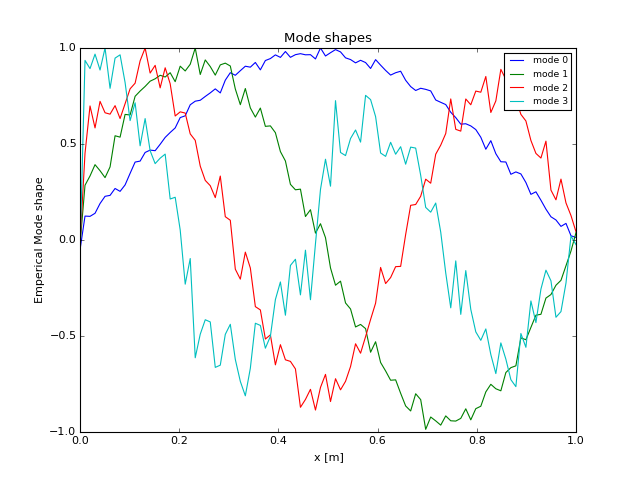

(<matplotlib.figure.Figure at 0x115b4c6d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115f28290>)

In [88]:
Cp,E=np.linalg.eig(C)
for i in range(np.shape(E)[1] ):
    ii = np.argmax(np.abs(E[:,i]))
    E[:,i]=E[:,i]/E[ii,i]
E = E/np.max(np.abs(E),axis=0)
def plotit():
    fig,ax=plt.subplots(1,1)
    col=['b','g','r','c']
    for m in range(4):
        ax.plot(x,E[:,m],label='mode %d'%m,color=col[m])
    ax.legend(fontsize='small')
    plt.title('Mode shapes')
    plt.xlabel('x [m]')
    plt.ylabel('Emperical Mode shape')
    return fig,ax
plotit()

So here we see the first 4 "modes".  These are close to the theoretical within an arbitrary sign of the mode shape:

<IPython.core.display.Javascript object>


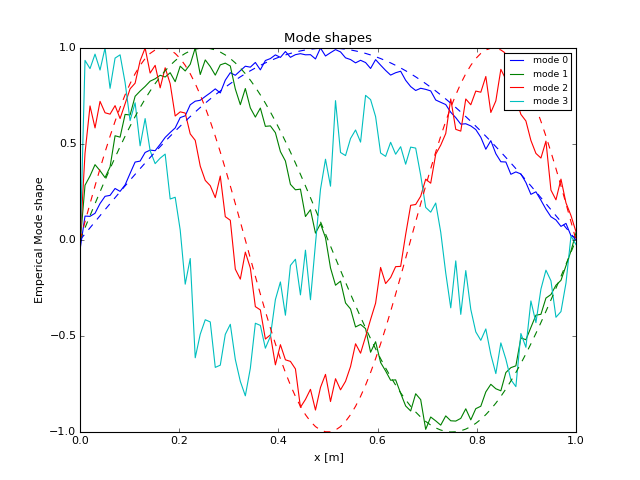

In [89]:
#sig=[-1,1,1,1]
fig,ax=plotit()
for m in range(3):
    ax.plot(x,np.sin(k[m]*x),color=col[m],linestyle='--')


There is noise, but the results are physically meaningful.  

We "rotate" the data $y'=E^{-1}y$ to get the time series of each of the modes, and plot:

<IPython.core.display.Javascript object>


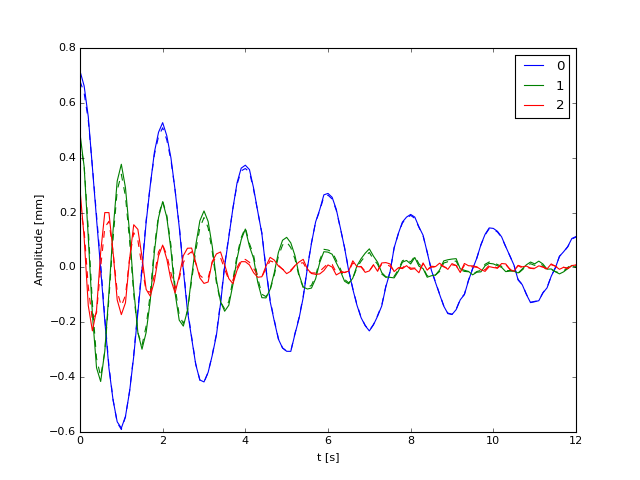

In [92]:
yme = np.dot(np.linalg.inv(E),y.T)
fig,ax=plt.subplots()
for m in range(0,3):
    ax.plot(t,yme[m,:],label='%d'%m,color=col[m])
    ax.plot(t,Am[:,m],linestyle='--',color=col[m])
plt.xlim([0,12])
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('Amplitude [mm]')

The time series is quite good, (though sometimes there will be a sign difference). 

Again, to summarize, the advantage of the EOF method is that we did not know the shape of the modes *a-priori* and that this technique returns a good representation of the shape of those modes.

Just to see how the modes fit together to make the original time-space series.  Recall that 

In [104]:
print np.shape(yme[m,:])
print np.shape(E[:,m])
print np.shape(np.outer(yme[m,:],E[:,m]))


(300,)
(100,)
(300, 100)


<IPython.core.display.Javascript object>


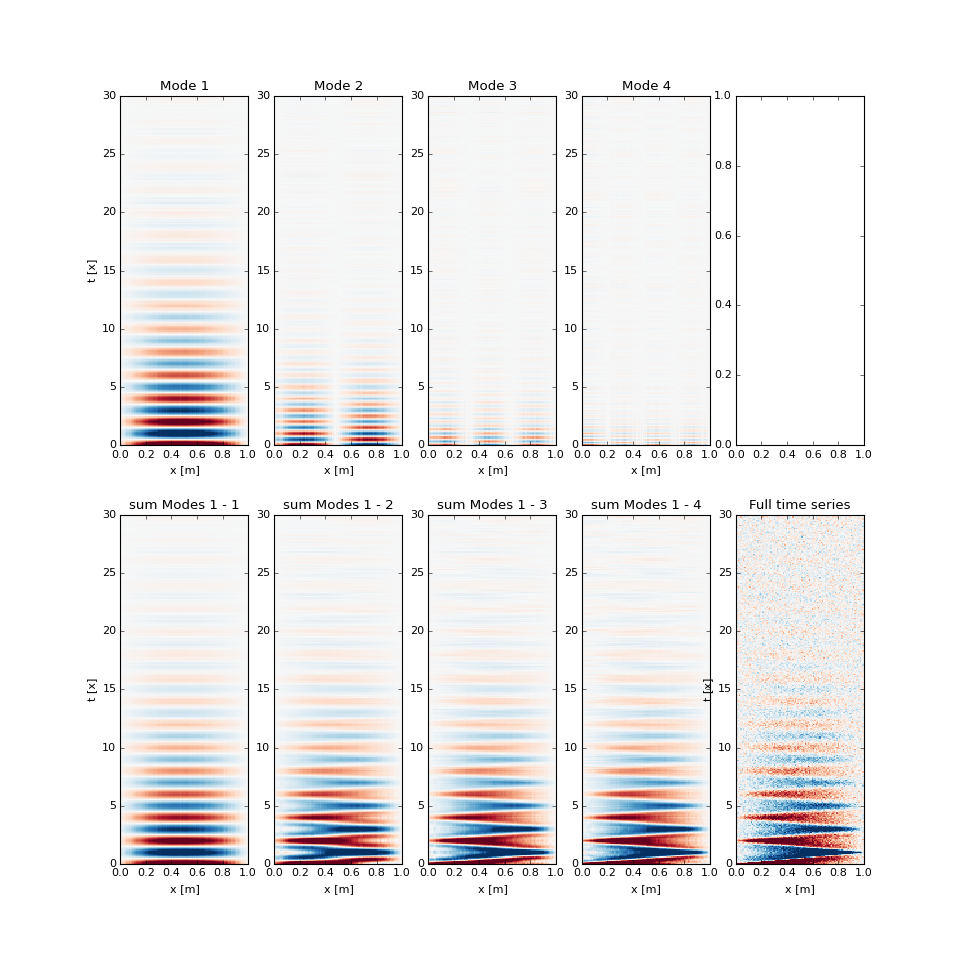

In [121]:
fig,axs = plt.subplots(2,5,figsize=(12,12))

ys = 0
for m in range(4):
    ax=axs[0,m]
    yy = np.outer(yme[m,:],E[:,m])
    pcm=ax.pcolormesh(x,t,yy,cmap=plt.cm.RdBu_r)
    pcm.set_clim((-0.4,0.4))
    #fig.colorbar(pcm,ax=ax,shrink=0.5)
    ax.set_xlabel('x [m]')
    if m==0:
        ax.set_ylabel('t [x]')
    ax.set_title('Mode %d'%(m+1))
    # cumulative:
    ax=axs[1,m]
    ys+=yy
    pcm=ax.pcolormesh(x,t,ys,cmap=plt.cm.RdBu_r)
    pcm.set_clim((-0.4,0.4))
    #fig.colorbar(pcm,ax=ax,shrink=0.5)
    ax.set_xlabel('x [m]')
    if m==0:
        ax.set_ylabel('t [x]')
    ax.set_title('sum Modes 1 - %d'%(m+1))
ax=axs[1,m+1]
pcm=ax.pcolormesh(x,t,y,cmap=plt.cm.RdBu_r)
pcm.set_clim((-0.4,0.4))
#fig.colorbar(pcm,ax=ax,shrink=0.5)
plt.xlabel('x [m]')
plt.ylabel('t [x]')
ax.set_title('Full time series')

Adding the sucessive modes makes the response look more like the full time series (lower right).  Summing upt ot mode 4 does not get all the noise (which would require more high-modes), but it captures the most important parts of the signal.

## Caveats:

EOFs aren't magic.  The assumption is that real physical modes are orthogonal to each other, which is not always the case.  Imagine a pendulum that traces out a smiley-face curve in $x-y$.  The data is not linearly dependent so a linear decomposition is not physically meaningful, even if it is possible:

## Summary

EOF's are quite simple: if you collect data at $N$ locations you 

  1. Compute the covariance matrix with the covariance taken over time (remmeber to remove the mean in time from each of your observations), so the covariance matrix is $N\times N$.
  2. You diagonalize the matrix and find the EigenVectors:
      `Cp,E=linalg.eig(C)`
  3. The columns of `E` are the "orthogonal modes" of the system.
  3. You can compute the amplitude of the "modes" in time as:
      `ym = np.dot(inv(E),y.T)`